In [2]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

2023-05-18 14:51:31.187209: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 14:51:31.190495: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 14:51:31.258101: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 14:51:31.259504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 14:51:32.380219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Redes neurais

### CNN (Sequential)

In [3]:
dt = 0.01; T = 8; t = np.arange(0,T+dt,dt)
beta = 8/3; sigma = 10; rho = 28
nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x, y, z = x_y_z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

In [4]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='sigmoid'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')
History = net.fit(nn_input, nn_output, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 4s 1ms/step - loss: 52.2144
Epoch 2/30
2500/2500 [==============================] - 3s 1ms/step - loss: 2.9340
Epoch 3/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.8208
Epoch 4/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4504
Epoch 5/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2840
Epoch 6/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1616
Epoch 7/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0972
Epoch 8/30
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0676
Epoch 9/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.0534
Epoch 10/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.0432
Epoch 11/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.0368
Epoch 12/30
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0318


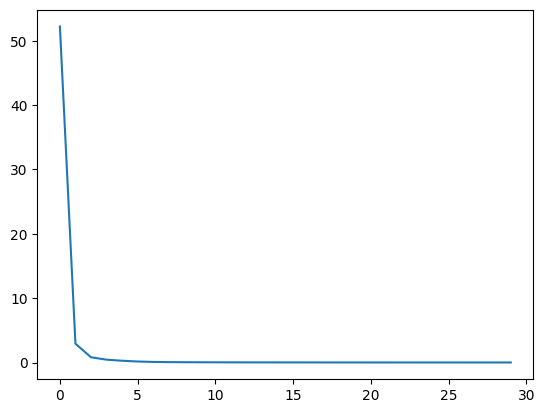

In [5]:
# plot loss history
plt.plot(History.history['loss'])

In [6]:
print(t[:-1].shape)

(800,)


Melhor do que tentar prever próximos estados destas trajetórias existentes, vamos tentar prever o comportamento de duas trajetórias completamente novas (mas integrantes ao sistema para qual a rede foi treinada).

In [7]:
# 2 trajetórias
num_traj = 2

ynn = np.zeros((num_traj, len(t), 3))
ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))
for jj, tval in enumerate(t[:-1]):
    ynn[:, jj+1, :] = net.predict(ynn[:, jj, :], verbose=1)

1/1 [==============================] - 0s 25ms/step


In [8]:
ynn.shape

(2, 801, 3)

In [9]:
# solve ODE, the two trajectories
y_t_1 = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t)
y_t_2 = integrate.odeint(lorenz_deriv, ynn[1, 0, :], t)
y_t_1

array([[ 9.23824024, -5.39363746, 11.88216864],
       [ 7.91763982, -3.93737215, 11.17568304],
       [ 6.85322268, -2.64529108, 10.64247136],
       ...,
       [11.21310171,  3.26384599, 37.72676539],
       [10.40491608,  2.22138344, 37.02555429],
       [ 9.58226712,  1.34041806, 36.22594479]])

In [10]:
y_t_2

array([[ -1.85034493, -11.25514799,  -9.05707795],
       [ -2.77838992, -11.99139716,  -8.55289389],
       [ -3.70346004, -13.04050729,  -7.92737233],
       ...,
       [ -0.7747702 ,  -2.36492924,  20.93778597],
       [ -0.92784427,  -2.4036306 ,  20.40687838],
       [ -1.07078442,  -2.45791227,  19.89387659]])

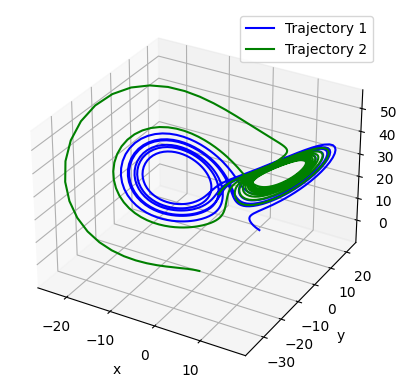

In [11]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2'])
plt.show()

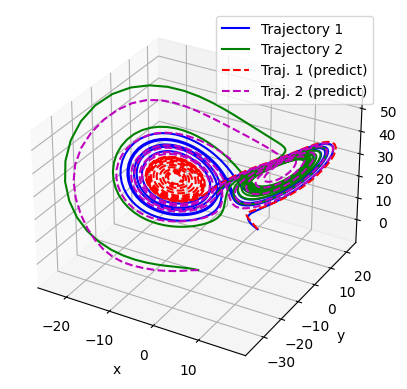

In [14]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
# ynn = np.zeros((num_traj, len(t), 3))
ynn_1 = ynn[0, :, :]
ynn_2 = ynn[1, :, :]
# plot ynn_1 (red, dotted line)
ax.plot(ynn_1[:, 0], ynn_1[:, 1], ynn_1[:, 2], 'r--')
# plot ynn_2 (pink, dotted line)
ax.plot(ynn_2[:, 0], ynn_2[:, 1], ynn_2[:, 2], 'm--')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2', 'Traj. 1 (predict)', 'Traj. 2 (predict)'])
plt.show()

In [ ]:
# TODO: comentar melhor
# TODO: LSTM

### RNN (LSTM)

TODO

## Métodos numéricos

### SINDy

TODO